# A/B-тестирование

# Описание проекта

**Постановка задачи**

В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.  

Требуется:  

- Оценить корректность проведения теста;
- Проанализировать результаты теста

Для оценки корректностьи проведения теста, необходимо проверить:

- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
    
**Техническое задание**

*Название теста:* recommender_system_test;        
*Группы:* А — контрольная, B — новая платежная воронка;  
*Дата запуска:* 2020-12-07;    
*Дата остановки набора новых пользователей:* 2020-12-21;     
*Дата остановки:* 2021-01-04;  
*Аудитория:* 15% новых пользователей из региона EU;  
*Назначение теста:* тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;  
*Ожидаемое количество участников теста:* 6000;   
*Ожидаемый эффект:* за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:  
   - конверсии в просмотр карточек товаров - `product_page`,    
   - просмотры корзины — `product_cart`,  
   - покупки — `purchase`.  

*Примечание:* В данном проекте используется библиотека Plotly, графики которой не отображаются на GitHub (здесь они заменены скриншотами). 
Для интерактивного отображения графиков Plotly рекомендуется открывать данный проект через [nbviewer](https://nbviewer.org/github/aefr1/data-analysis-projects/blob/main/ab_testing/ab_testing.ipynb)  

# Цель проекта 

Провести оценку результатов A/B-теста


# Описание данных

*Датасет ab_project_marketing_events.csv* (календарь маркетинговых событий на 2020 год)

**name** — название маркетингового события;  
**regions** — регионы, в которых будет проводиться рекламная кампания;  
**start_dt** — дата начала кампании;  
**finish_dt** — дата завершения кампании.  

*Датасет final_ab_new_users.csv* (пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года)

**user_id** — идентификатор пользователя;  
**first_date** — дата регистрации;  
**region** — регион пользователя;  
**device** — устройство, с которого происходила регистрация.  

*Датасет final_ab_events.csv* (действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года)  

**user_id** — идентификатор пользователя;  
**event_dt** — дата и время покупки;  
**event_name** — тип события;  
**details** — дополнительные данные о событии. Например, для покупок `purchase`, в этом поле хранится стоимость покупки в долларах.  

*Датасет final_ab_participants.csv* (таблица участников тестов)

**user_id** — идентификатор пользователя;  
**ab_test** — название теста;  
**group** — группа пользователя.    

# Содержание  

1 Обзор и предобработка данных  
1.1 Импорт библиотек и загрузка данных  
1.2 Предобработка данных  
1.3 Вывод  
2 Оценка корректности проведения теста  
2.1 Проверка на соответствие данных требованиям технического задания   
2.2 Маркетинговые активности во время проведения теста и их влияние  
2.3 Оценка аудитории теста  
2.4 Вывод  
3 Исследовательский анализ данных  
3.1 Распределение количества событий на пользователя в выборках  
3.2 Распределение числа событий в выборках по дням  
3.3 Изменение конверсии в воронке в выборках на разных этапах  
4 Оценка результатов A/B-тестирования  
5 Выводы по исследованию данных и по оценке результатов A/B-тестирования  

## 1 Обзор и предобработка данных

### 1.1 Импорт библиотек и загрузка данных

Импортируем библиотеки:

In [40]:
import pandas as pd
from plotly import graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth

Загружаем данные:

In [41]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

Посмотрим первые  строк датасетов, общую информацию и проверим на пропуски и дубликаты. Поскольку задачи однотипные, запустим их в цикле по всем датасетам:

In [42]:
for df in [marketing_events, new_users, events, participants]:
    display(df.head())
    print()
    display(df.info())
    print()
    print(f' Кол-во пропусков:\n {df.isna().sum()}')
    print()
    print()
    print(f' Кол-во дубликатов: {df.duplicated().sum()}')
    print()


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None


 Кол-во пропусков:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


 Кол-во дубликатов: 0



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None


 Кол-во пропусков:
 user_id       0
first_date    0
region        0
device        0
dtype: int64


 Кол-во дубликатов: 0



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None


 Кол-во пропусков:
 user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


 Кол-во дубликатов: 0



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None


 Кол-во пропусков:
 user_id    0
group      0
ab_test    0
dtype: int64


 Кол-во дубликатов: 0



Обзор показал, что в таблицах *marketing_events*, *new_users* и *events* все столбцы с датами имеют неверный тип данных, а в таблице *events* есть пропуски. В описании данных указано, что в столбце *details* хранятся дополнительные данные о событиях, в частности для покупок - *purchase*, следовательно, заполнение данного столбца не являлось обязательным. Сгруппируем данные по типам событиям и посмотрим пропуски:

In [43]:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

Действитетельно, пропуски есть для всех событий, кроме покупок, следовательно не обращием на на них внимание.

### 1.2 Предобработка данных

Приведем нужному типу все столбцы с датами. Для однотипных действий применим функцию:

In [46]:
def date_type(df, col):
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    df.info()
    print('=======================================')

In [47]:
date_type(marketing_events, 'start_dt')
date_type(marketing_events, 'start_dt')
date_type(new_users, 'first_date')
date_type(events, 'event_dt')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 column

Все даты теперь в нужном формате. В столбце *event_dt* таблицы *events* собрана информация о дате и времени события. Для удобства работы с данными, создадим еще один дополнительный столбец с датой - *event_date*:

In [48]:
events['event_date'] = events['event_dt'].dt.date

Объединим теперь таблицы participants, new_users и events по общему столбцу user_id:

In [49]:
df = participants.merge(new_users, on='user_id', how='left').merge(events, on='user_id', how='left')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   first_date  110368 non-null  datetime64[ns]
 4   region      110368 non-null  object        
 5   device      110368 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
 9   event_date  106625 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 9.3+ MB


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


Объединение данных прошло успешно. В столбцах от присоединенной таблицы *events* теперь есть пропущенные значения, это нормально, поскольку в них собраны события и не все пользователи должны были их совершать.

### 1.3 Вывод

**На этапе обзора и предобработки данных можно выделить следующее:**  

<br> 1. В столбце *details* таблицы *events* найдены пропуски. Установлено, что в этом столбце хранится только дополнительная информация о стоимости покупок для событий purchase, что соответствует описанию данных. На этом основании пропуски оставлены без изменений.

<br> 2. Обнаружен неверный тип данных в столбцах с датами в  таблиц *marketing_events*, *new_users* и *events*. Данные приведены к нужному типу. 

<br> 3. Для удобства работы с данными в таблицу *events* добавлен столбец с датой *events_date* (без времени).

<br> 4. Таблицы *participants*, *new_users* и *events* объединены в один датасет по общему столбцу *user_id*

## 2 Оценка корректности проведения теста

### 2.1 Проверка на соответствие данных требованиям технического задания

***Название теста*** (recommender_system_test):

In [50]:
df['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В таблице собрана информация о двух тестах. Название теста "recommender_system_test" ТЗ **соответствует**. Очистим ненужные данные:

In [51]:
df.query('ab_test == "recommender_system_test"')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07
...,...,...,...,...,...,...,...,...,...,...
27719,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN,2020-12-07
27720,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN,2020-12-08
27721,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN,2020-12-09
27722,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN,2020-12-10


In [52]:
metering = len(df)
df = df.query('ab_test == "recommender_system_test"')
print('Удалено {:.1%} данных, относящихся к другому тесту.'.format(1 - len(df) / metering))

Удалено 74.9% данных, относящихся к другому тесту.


***Группы*** (A — контрольная, B — новая платёжная воронка):

In [53]:
df['group'].unique()

array(['A', 'B'], dtype=object)

Участники распределены по двум группам A и B. Группы ТЗ **соответствуют**.

***Дата запуска*** (2020-12-07):

In [54]:
df['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Дата запуска ТЗ **соответствует**.

***Дата остановки набора новых пользователей*** (2020-12-21):

In [55]:
df['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей ТЗ **соответствует**.

***Дата остановки*** (2021-01-04):

In [56]:
df['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

Дата остановки **не соответствует** ТЗ. Остановка произошла раньше установленного срока, возможно по причине возникновения каких-либо  трудностей технического характера.

***Аудитория:*** (15% новых пользователей из региона EU):

In [57]:
df['region'].unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

В датасете присутствуют пользователи из других регионов, их участие в тесте по условиям ТЗ не требуется. Очистим данные и посчитаем результат:

In [58]:
metering = len(df)
df = df.query('region == "EU"')
print('Удалено {:.1%} данных, не соответствующих ТЗ.'.format(1 - len(df) / metering))
print('Аудитория новых пользователей из региона EU составляет {0:.1%}'
      .format(df.query('first_date <= "2020-12-21"')['user_id'].nunique() /
                       new_users.query('region == "EU" & first_date <= "2020-12-21"')['user_id'].nunique()))

Удалено 5.2% данных, не соответствующих ТЗ.
Аудитория новых пользователей из региона EU составляет 15.0%


Аудитория **соответствует** ТЗ.

***Ожидаемое количество участников теста:*** (6000):

In [59]:
print('Количество участников теста - ', df['user_id'].nunique(),
      'что составляет {:.1%}'.format(df['user_id'].nunique() / 6000), 'от ожидаемого в ТЗ количества')

Количество участников теста -  6351 что составляет 105.8% от ожидаемого в ТЗ количества


Количество участников теста на 5,8% больше, т.е. **не соответствует** ТЗ.

**Вывод:**
В результате проверки соответствия данных требованиям ТЗ, установлено следующее:
1. Соответствуют ТЗ:
- название теста;
- группы;
- дата запуска;
- дата остановки набора новых пользователей;
- аудитория.

2. Не соответствуют ТЗ:
- дата остановки;
- ожидаемое количество участников.
3. Кроме того, были найдены данные, относящихся к другому тесту (interface_eu_test), а также участники теста recommender_system_test из других регионов (N.America, CIS, APAC), участие которых по условиям ТЗ в тесте не требовалось. Все лишние данные удалены.

Дата остановки тестирования раньше срока, безусловно, является серьезным нарушением ТЗ, поскольку у некоторых пользователей лайфтайм будет составлять менее 14 дней. С другой стороны, удаление большого количества данных может повлечь за собой искажение результатов теста. Поэтому удалять таких пользователей пока не будем.

### 2.2 Маркетинговые активности во время проведения теста и их влияние

Посмотрим, какие маркетинговые активности совпали со временем проведения теста:

In [60]:
marketing_events.query('start_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


События всего два, а в интересующем нас регионе - всего одно: *Christmas&New Year Promo*. Посмотрим, заметно ли менялась активность Европейских пользователей по событиям с момента запуска этой промо-акции:  

In [61]:
# создаем сводную таблицу с группировкой по дате и расчетом кол-ва пользователей по событмям
to_scatter = df.pivot_table(index='event_date', columns='event_name', values=['user_id'], aggfunc='count').reset_index()
to_scatter.columns = ['Дата события', 'Авторизация', 'Корзина', 'Страница продукта', 'Покупка']

# строим гистограмму:
fig = go.Figure()
fig.add_trace(go.Scatter(x=to_scatter['Дата события'], y=to_scatter['Авторизация'], name='Авторизация'))
fig.add_trace(go.Scatter(x=to_scatter['Дата события'], y=to_scatter['Корзина'], name='Корзина'))
fig.add_trace(go.Scatter(x=to_scatter['Дата события'], y=to_scatter['Страница продукта'], name='Страница продукта'))
fig.add_trace(go.Scatter(x=to_scatter['Дата события'], y=to_scatter['Покупка'], name='Покупка'))
fig.update_layout(title='Активность пользователей Европейского региона по видам событий', yaxis_title='количество пользователей')
fig.show()

**Скриншот графика Plotly для сайта GitHub** (для просмотра графика в интерактивном виде можно использовать [nbviewer](https://nbviewer.org/github/aefr1/data-analysis-projects/blob/main/ab_testing/ab_testing.ipynb))  
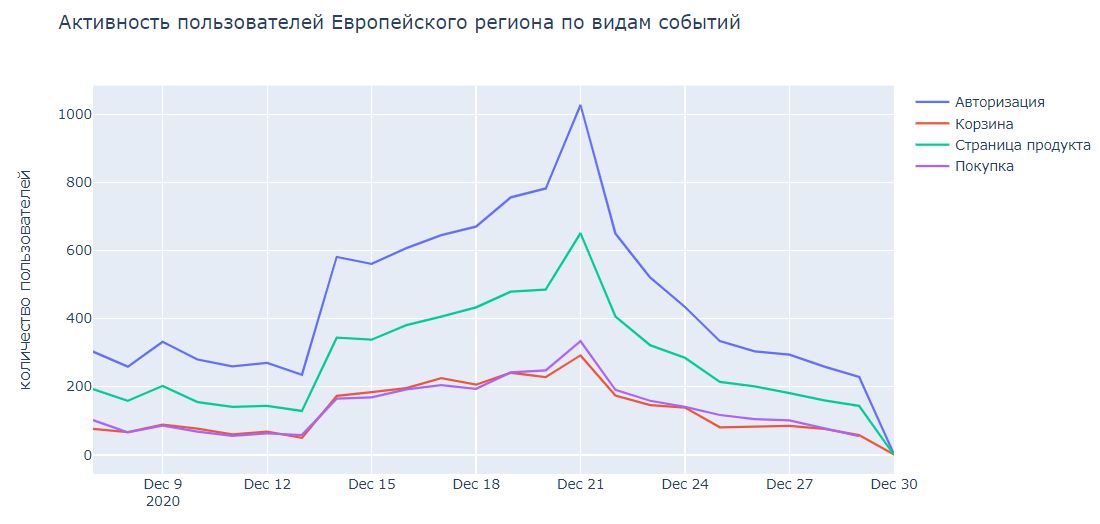

На графике наблюдается рост активности пользователей, пик которой приходится на 21 декабря, и вероятнее всего он связан с традиционной активностью покупателей перед празднованием католического Рождества. В момент старта промо-акции Christmas&New Year Promo 25 декабря никакой дополнительной активности не замечено, а наоборот, продолжается ее снижение. Поэтому будем считать, что существенного влияния эта промо-акция на покупателей не оказала, и дополнительной корректировки данных в связи с этим не требуется.

### 2.3 Оценка аудитории теста

Как уже было отмечено ранее, в изначальных данных была информация по еще одному тесту - *interface_eu_test*. Эти данные были отфильтрованы, но в оставшихся данных могут оставаться пользователи, участвовшие в том тесте. **Проверим, есть ли пользователи, участвовшие в двух тестах**. Проверим пересечения в сырых данных:

In [62]:
participants.groupby('user_id').agg({'ab_test' : 'nunique'}).query('ab_test > 1').count()

ab_test    1602
dtype: int64

**Действительно, 1602 пользователя участвовало в двух тестах**. Создадим список с идентификаторами пользователей попавших в обе группы и посмотрим в очищенном датасете количество таких пользователей по группам:

In [63]:
double_users = participants.groupby('user_id').agg({'ab_test' : 'nunique'}
                                                  ).reset_index().query('ab_test > 1')['user_id'].unique()
print('В группе A - {} пользователь, участвовавший в двух тестах.'
      .format(df.query('user_id in @double_users & group == "A"')['user_id'].nunique()))
print('В группе B - {} пользователь, участвовавший в двух тестах.'
      .format(df.query('user_id in @double_users & group == "B"')['user_id'].nunique()))

В группе A - 921 пользователь, участвовавший в двух тестах.
В группе B - 681 пользователь, участвовавший в двух тестах.


Да, такие пользователи есть. Теперь **проверим, нет ли пользователей, оказавшихся в группе А и в группе В одновременно**:

In [64]:
cross_users_a = participants.query('group == "A" & ab_test == "interface_eu_test" & user_id in @double_users'
                                   ).groupby('user_id').agg({'ab_test' : 'nunique'}
                                                            ).reset_index()['user_id'].unique()
cross_users_b = participants.query('group == "B" & ab_test == "interface_eu_test" & user_id in @double_users'
                                    ).groupby('user_id').agg({'ab_test' : 'nunique'}
                                                             ).reset_index()['user_id'].unique()
print('В группе A - {} пользователей, участвовавших в тесте interface_eu_test группы В'
      .format(df.query('user_id in @cross_users_b & group == "A"')['user_id'].nunique()))
print('В группе B - {} пользователей, участвовавших в тесте interface_eu_test группы А'
      .format(df.query('user_id in @cross_users_a & group == "B"')['user_id'].nunique()))

В группе A - 439 пользователей, участвовавших в тесте interface_eu_test группы В
В группе B - 337 пользователей, участвовавших в тесте interface_eu_test группы А


И такие пользователи оказались в нашем датасете, и счет их на сотни. Посмотрим, есть ли пересечения среди участников  теста recommender_system_test:

In [65]:
df.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

Хотя бы здесь без сюрпризов, среди участников нашего теста таких пересечений нет.   
И все же факт того, что пользователи перекрестно попали в обе группы (хотя и разных тестов), и в таком большом количестве, говорит о плохой подготовке к тестированию. В нашем случае, возможности исправить старые ошибки уже нельзя, и выбор по сути стоит между плохим и очень плохим. Очень плохим в данном случае является удаление значительной части и так уже немногочисленных данных, поскольку сильно уменьшит размер выборки и ее репрезентативность. Кроме того, мы не имеем данных ни о времени проведения теста, ни о том, какие параметры он затрагивал. Также стоит отметить, что пользватели с участием в двух тестах есть и в группе А и в группе В, поэтому, в случае наличия какого-либо влияния, оно будет оказано на обе выборки.

Теперь можно очистить данные от лишних столбцов *ab_test* и *region*:

In [66]:
df.drop(columns=['ab_test', 'region'], inplace=True)
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   first_date  26290 non-null  datetime64[ns]
 3   device      26290 non-null  object        
 4   event_dt    23420 non-null  datetime64[ns]
 5   event_name  23420 non-null  object        
 6   details     3196 non-null   float64       
 7   event_date  23420 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 1.8+ MB


,user_id,group,first_date,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07


Обратим внимание на еще один момент - количество строк событий у нас меньше количества строк пользователей. Строки с пользователями, не совершавшими никаких событий, но имеющих временные метки, говорят нам об отсутствии действий после регистрации, либо наличии каких-то проблем - неудачной авторизации, или каких-либо еще технических накладок. Эти данные нам точно не пригодятся, удалим их:

In [67]:
df.dropna(subset=['event_name'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23420 entries, 0 to 26289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23420 non-null  object        
 1   group       23420 non-null  object        
 2   first_date  23420 non-null  datetime64[ns]
 3   device      23420 non-null  object        
 4   event_dt    23420 non-null  datetime64[ns]
 5   event_name  23420 non-null  object        
 6   details     3196 non-null   float64       
 7   event_date  23420 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 1.6+ MB


**Проверим равномерность распределения по тестовым группам и правильность их формирования**. При группировке столбцов будут применяться однотипные операции, поэтому подготовим функцию и посмотрим на распределение уникальных пользователей:

In [68]:
def ratio_analysis(column, query_trigger):
    if query_trigger == 0:
        ratio = df.groupby(column).agg(users=('user_id', 'nunique')).reset_index()
        ratio['ratio'] = ratio['users']/ ratio['users'].sum()
        display(ratio.style.format('{:.1%}', subset='ratio').hide(axis='index'))
    else:
        print('\033[1m''Распределение уникальных \n пользователей группы А:''\033[0m')
        ratio = df.query('group == "A"').groupby(column).agg(users=('user_id', 'nunique')).reset_index()
        ratio['ratio'] = ratio['users']/ ratio['users'].sum()
        display(ratio.style.format('{:.1%}', subset='ratio').hide(axis='index'))
        print()
        print('\033[1m''Распределение уникальных \n пользователей группы В:''\033[0m')
        ratio = df.query('group == "B"').groupby(column).agg(users=('user_id', 'nunique')).reset_index()
        ratio['ratio'] = ratio['users']/ ratio['users'].sum()
        display(ratio.style.format('{:.1%}', subset='ratio').hide(axis='index'))
        print('=============================')
        print()

In [69]:
ratio_analysis('group', 0)

group,users,ratio
A,2604,74.8%
B,877,25.2%


Группы сформированы крайне неравномерно, в контрольной группе А пользователей в три раза больше. Это безусловно отразится на результатах исследования, поскольку уверенность в оценке меньшей группы будет ниже, т.к. будет более шумной. Но поскольку вернуться к этапу подготовки теста и все исправить невозможно, будем работать с тем, что есть.  
Посмотрим, как распределились уникальные пользователи по устройствам и событиям:

In [70]:
ratio_analysis('device', 1)
ratio_analysis('event_name', 1)

Распределение уникальных 
 пользователей группы А:


device,users,ratio
Android,1139,43.7%
Mac,255,9.8%
PC,689,26.5%
iPhone,521,20.0%



Распределение уникальных 
 пользователей группы В:


device,users,ratio
Android,405,46.2%
Mac,74,8.4%
PC,212,24.2%
iPhone,186,21.2%



Распределение уникальных 
 пользователей группы А:


event_name,users,ratio
login,2604,44.1%
product_cart,782,13.2%
product_page,1685,28.5%
purchase,833,14.1%



Распределение уникальных 
 пользователей группы В:


event_name,users,ratio
login,877,47.1%
product_cart,244,13.1%
product_page,493,26.5%
purchase,249,13.4%


Здесь распределение выглядит значительно лучше, по данным параметрам группы выглядят однороднее.

### 2.4 Вывод

**Оценка корректности проведения теста показала следующее:**

<br>  1. Установлено соответствие техническому заданию таких параметров, как название теста, наличие групп A и В, дата запуска теста, дата остановки набора новых пользователей и аудитория. Не соответствуют техническому заданию дата остановки теста и количество участников. Самым серьезным нарушением из перечисленного является досрочная остановка теста, поскольку это может повлечь за собой уменьшение необходимого лафтайма (14 дней) для некоторых пользователей. Однако, удаление значительных массивов данных снижает репрезентативность выборок, на основании чего принято решение данные пользователей по этой части не удалять и продолжить изучение. 

<br> 2. Также были найдены данные, относящихся к другому тесту (interface_eu_test), а также участники теста recommender_system_test из других регионов (N.America, CIS, APAC), участие которых по условиям ТЗ в тесте не требовалось. Все лишние данные удалены.  

<br>  3. Установлено, что в период с 25 декабря, одновременно с тестированием, на Европейском пространстве проходила промо-акция Christmas&New Year Promo. На основе изучения графика активности пользователей какого-либо влияния на действия пользователей не замечено, на основании чего принято решение об отсутствии необходимости внесения корректировок по этой части.  

<br>  4. Обнаружены 1602 пользователя, участвовавших в двух тестах, в группе А оказалось 921 пользователь, в группе В - 681. Кроме того, зафиксировано перекрестное попадание участников контрольной группы нашего теста в экспериментальную теста interface_eu_test, и наоборот. В группе A оказалось 439 таких пользователей, в группе B - 337. Проверка внутри теста recommender_system_test таких проблем не выявила.   
Совпадал ли период тестирования с тестом interface_eu_test, и какие параметры он затрагивал, установить не представляется возможным из-за отсутствия таких данных. Также отмечено, что такие пользователи входят в обе группы, и при наличии влияния, оно будет оказано на обе выборки и не должно сильно искажать результаты нашего теста. По совокупности фактов было принято решение оставить данные, связанные с этими пользователями.  

<br>  5. Изучение равномерности распределения по группам показало, что контрольная (А) и экспериментальная (В) группы сформированы неравномерно, в группе А находится значительно больше пользователей, что может снизить уверенность в оценке результатов теста. В то же время, пока отсутствуют критерии, по которым можно выровнять кол-во участников тестирования без увеличения погрешности. При этом, стоит отметить, что распределение уникальных пользователей по типам устройств и типам событий выглядит приемлемым.

## 3 Исследовательский анализ данных

### 3.1 Распределение количества событий на пользователя в выборках

Посчитаем, сколько в среднем событий приходится на одного пользователя в каждой группе:

In [71]:
events_avg = df.groupby('group')[['event_name', 'user_id']].agg({'event_name':'count', 'user_id':'nunique'}
                                                               ).reset_index()

events_avg['avg'] = events_avg['event_name'] / events_avg['user_id']
events_avg.style.format('{:.2f}', subset='avg').hide(axis='index')

group,event_name,user_id,avg
A,18309,2604,7.03
B,5111,877,5.83


Среднее значение в группе А больше. Посмотрим медиану и распределение на графике:

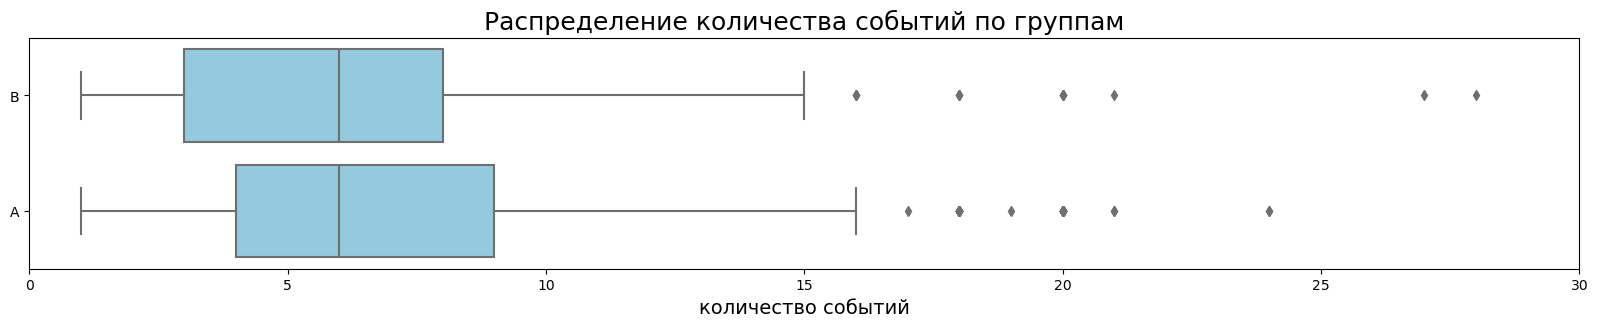

In [72]:
plt.figure(figsize=(20, 3))
events_distr = df.groupby(['user_id','group'])['event_name'].count().reset_index()
sns.boxplot(data=events_distr, x='event_name', y='group', color='skyblue') 
plt.title('Распределение количества событий по группам', size=18)
plt.xlabel('количество событий', size=14)
plt.xlim([0,30])
plt.ylabel(None)
plt.show()

В группе А на пользователя приходится чуть больше событий как по среднему, так и по медиане. Посмотрим на плотность распределения событий в группах:

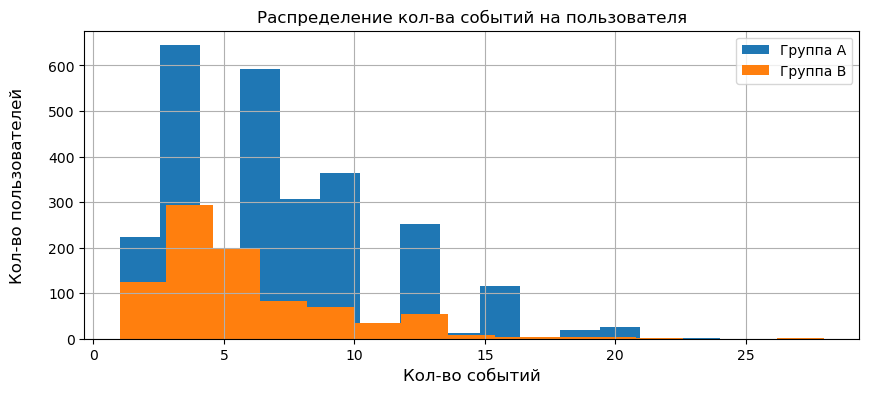

In [73]:
plt.figure(figsize=(10,4))
plt.hist(events_distr.query('group == "A"')['event_name'], label='Группа A', bins=15)
plt.hist(events_distr.query('group == "B"')['event_name'], label='Группа B', bins=15)
plt.xlabel('Кол-во событий', fontsize=12)
plt.ylabel('Кол-во пользователей\n ', fontsize=12)
plt.title('Распределение кол-ва событий на пользователя', fontsize=12)
plt.legend()
plt.grid()
plt.show()

События распределены по-разному, пользователи контрольной группы вели себя активнее, в группе B распределение плотнее.

### 3.2 Распределение числа событий в выборках по дням

Создадим сводную таблицу и выведем графики для каждой из групп:

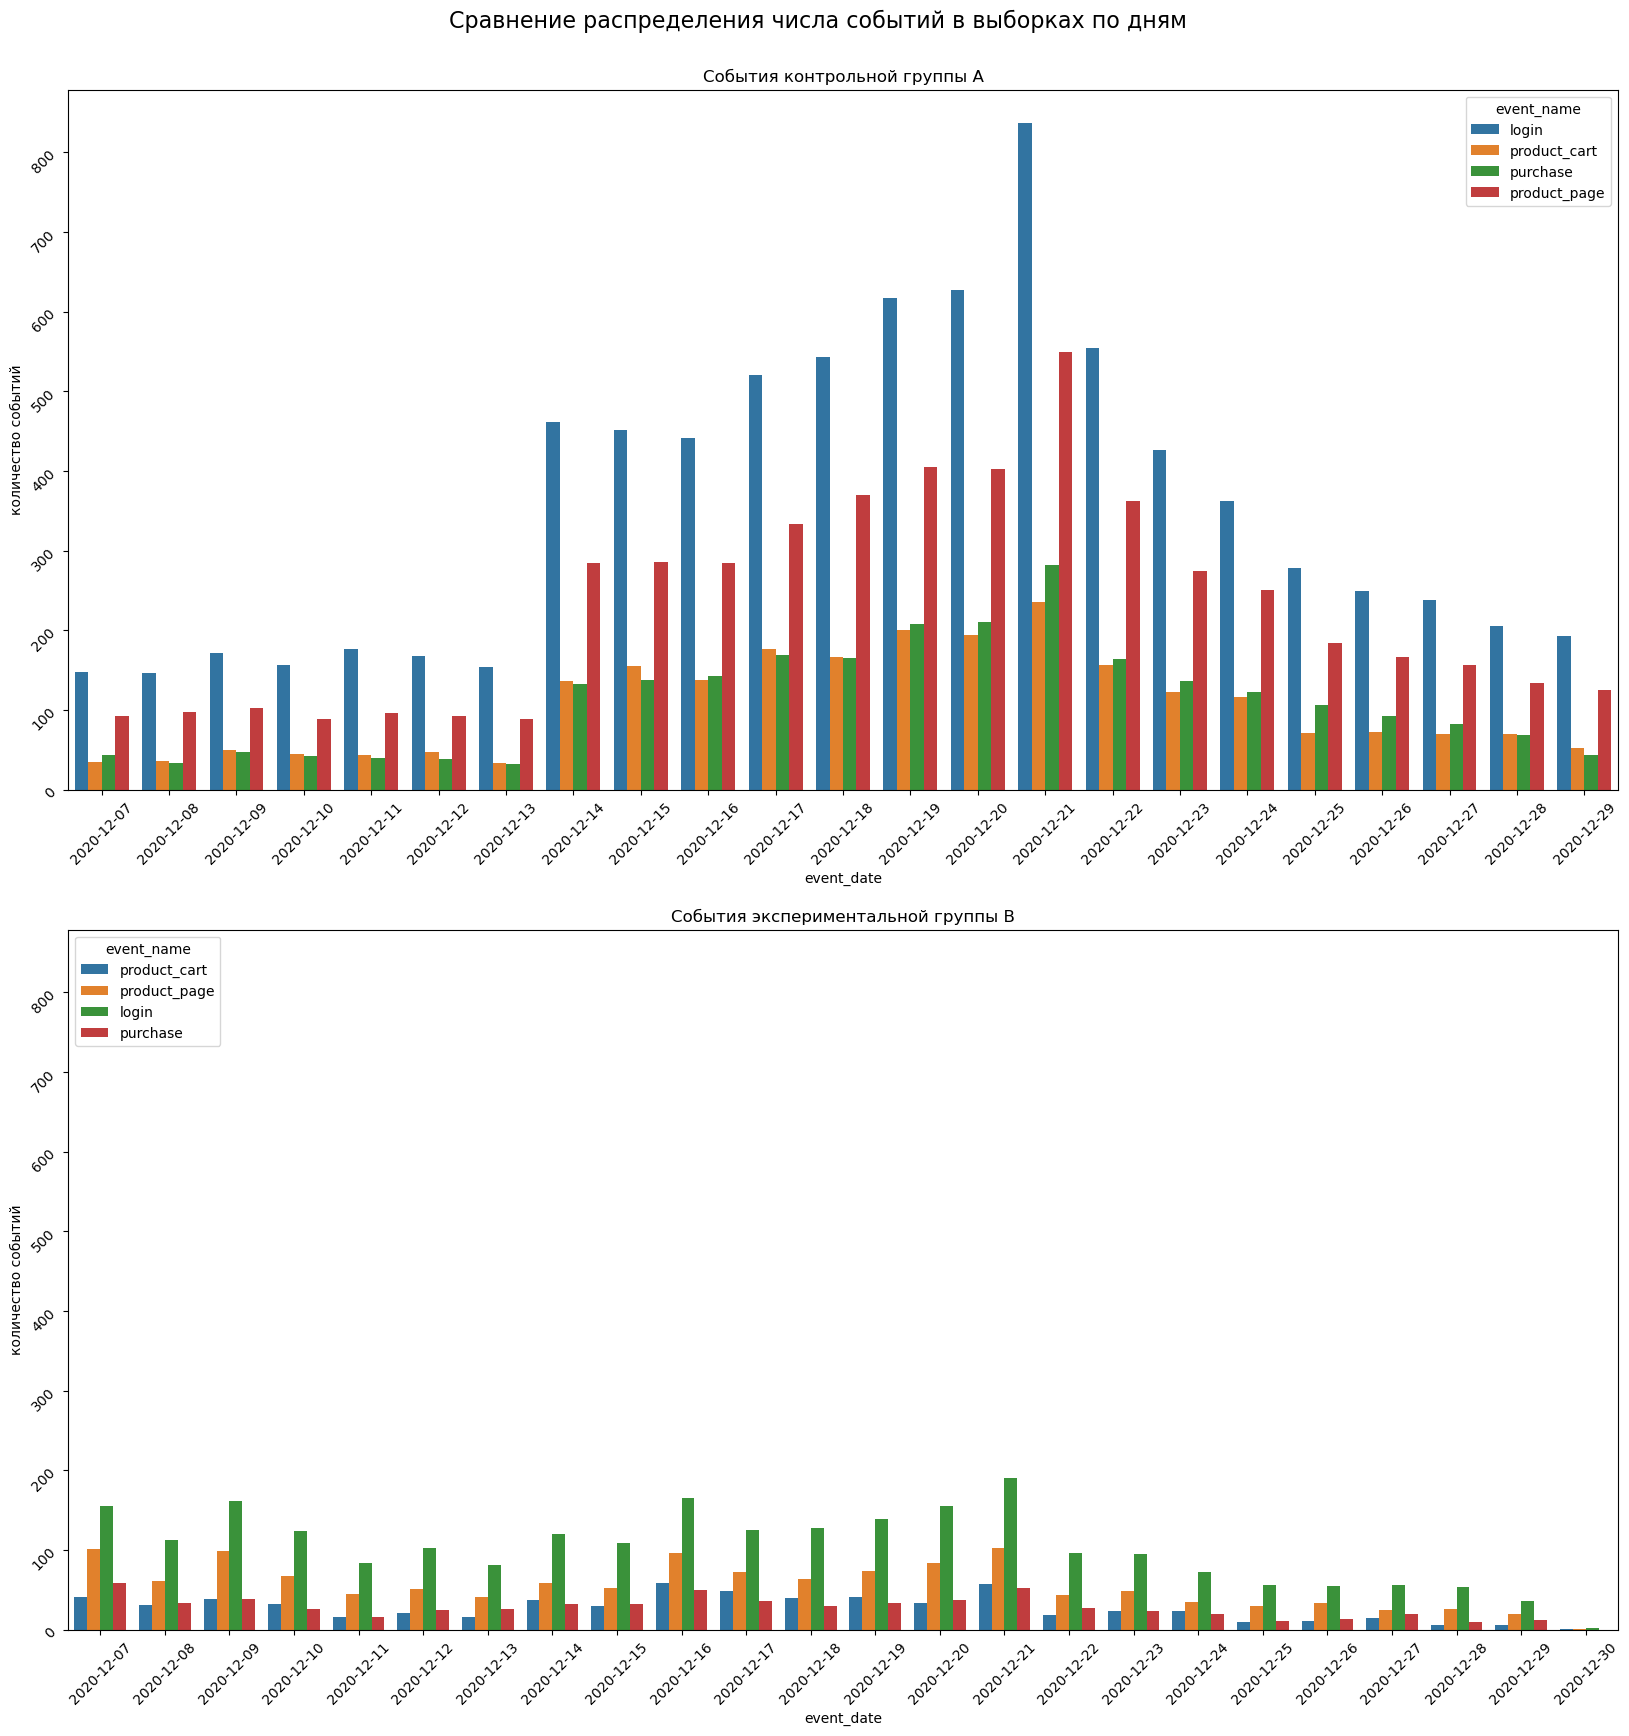

In [77]:
events_by_days = df.pivot_table(index=['event_name', 'group', 'event_date'], values='user_id', aggfunc='count'
                                ).reset_index().sort_values(by='event_date')
                  
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(20, 20));  # задаем параметры субплотов
fig.suptitle('Сравнение распределения числа событий в выборках по дням', fontsize=16, y=0.92)

sns.barplot(ax=axes[0], data=events_by_days.query('group == "A"'), y='user_id', x='event_date', hue='event_name')
axes[0].set_title('События контрольной группы A')
axes[0].tick_params(labelrotation=45)
axes[0].set_ylabel('количество событий')

sns.barplot(ax=axes[1], data=events_by_days.query('group == "B"'), y='user_id', x='event_date', hue='event_name')
axes[1].set_title('События экспериментальной группы В')
axes[1].tick_params(labelrotation=45)
axes[1].set_ylabel('количество событий')

plt.show()

На обоих графиках выделяется пик - 21 декабря, и затем идет снижение. Похоже, что основная часть пользователей совершает покупки в первые дни после регистрации, а 21 декабря как раз был последним днем для регистрации участников теста. В группе В активность упала раньше, 30 декабря активность присутствует только у контрольной группы.

### 3.3 Изменение конверсии в воронке в выборках на разных этапах

In [79]:
funnel_a = df.query('group == "A"'
                   ).groupby('event_name'
                            ).agg({'user_id': 'nunique'}
                                 ).sort_values('user_id', ascending=False
                                              ).reindex(['login', 'product_page', 'product_cart', 'purchase']
                                                       ).reset_index(drop=False)


funnel_b = df.query('group == "B"').groupby('event_name'
                            ).agg({'user_id': 'nunique'}
                                 ).sort_values('user_id', ascending=False
                                              ).reindex(['login', 'product_page', 'product_cart', 'purchase']
                                                       ).reset_index(drop=False)

fig = go.Figure()

fig.add_trace(go.Funnel(y=funnel_a['event_name'],
                        x=funnel_a['user_id'],
                        textposition= 'inside',
                        textinfo= 'value + percent initial',
                        name='Группа А',
                        marker = {'color': '#0000FF'}))
                        
fig.add_trace(go.Funnel(y=funnel_b['event_name'],
                        x=funnel_b['user_id'],
                        textinfo='value + percent initial',
                        name='Группа B',
                        marker = {'color': '#FF0000'})),

fig.update_layout(template='plotly_white',
                  title='Воронка событий')
fig.show()

**Скриншот графика Plotly для сайта GitHub** (для просмотра графика в интерактивном виде можно использовать [nbviewer](https://nbviewer.org/github/aefr1/data-analysis-projects/blob/main/ab_testing/ab_testing.ipynb))  
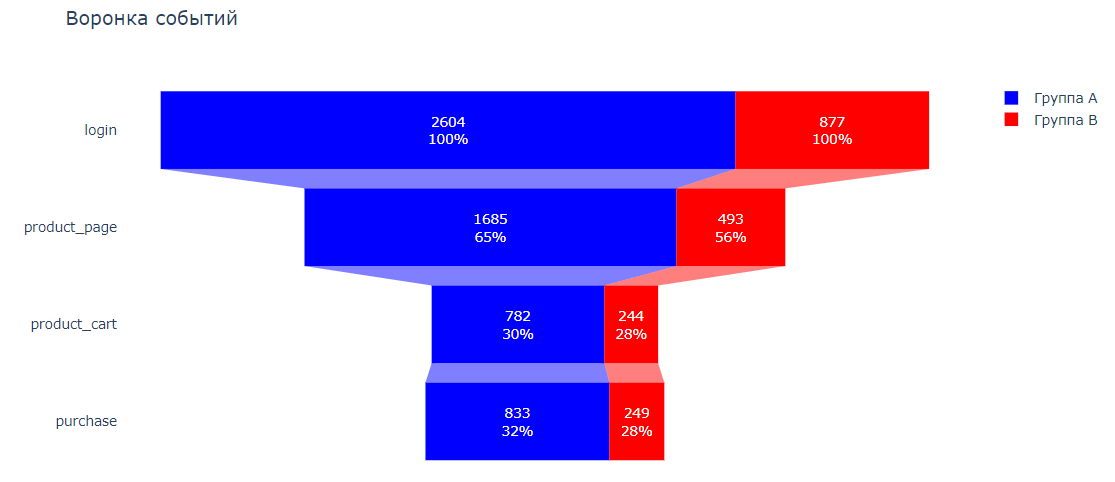

На воронке событий наглядно отображается несоразмерность групп. Конверсия по шагам сильно отличается на переходе к странице товара - 65% в группе А и 56% в группе В, этапы корзины и покупки выглядят схожим образом. Примечательно, что этап покупки имеет большую конверсию, чем корзина. Похоже, что функционалом такая возмоность заложена, что-то вроде "быстрой покупки". Для верного отображения графика пришлось применить переиндексацию. Больше всего пользователей теряется на переходе от авторизации к странице продукта, следует проверить, нет ли технических проблем на этом шаге.

**Прежде, чем приступать к тестированию, стоит еще раз сделать акцент на некоторых особенностях**: 
1. Группы имеют серьезный дисбаланс по количеству участников, а также несоответствие по общему количеству.
2. Тест завершен ранее запланированного срока - 29 декабря, в результате чего у части пользователей сократился лайфтайм. Данный эффект снивелирован особенностью активности покупателей - они совершают активные покупки только в первые дни после регистрации.
3. Фиксируется пик продаж 21 декабря, связанный с влиянием предпраздничного Рождественского ажиотажа.
4. Уже до оценки результатов, мы удостоверились, что тест в целом провален, целевой результат в виде улучшения метрик на 10% не получен, а достоверность собранных данных вызывает сомнение.

## 4 Оценка результатов A/B-тестирования

Сформулируем нулевую и альтернативную гипотезы: 
```
H_0: Различий в долях пользователей между группами A и B нет
H_1: Различия в долях пользователей между группами A и B есть
alpha = 0.05  
```
Уровень alpha установим стандартным, равным 0.05, но применим поправку Бонферрони, поскольку оценивать будем по 3-м событиям.

Для оценки результатов теста нам понадобится таблица с конверсией. Сгруппируем данные и посчитаем воронку по шагам:

In [80]:
df_z_test = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique'
                          ).sort_values(by='A', ascending=False
                                       ).reindex(['login', 'product_page', 'product_cart', 'purchase']).reset_index(drop=False)
users_by_group = df.groupby('group')['user_id'].nunique()
df_z_test['share_A'] = (df_z_test['A'] / users_by_group['A'] * 100).round(2)
df_z_test['share_B'] = (df_z_test['B'] / users_by_group['B'] * 100).round(2)

df_z_test

group,event_name,A,B,share_A,share_B
0,login,2604,877,100.00,100.00
1,product_page,1685,493,64.71,56.21
2,product_cart,782,244,30.03,27.82
3,purchase,833,249,31.99,28.39


Покольку нам предстоит работать с долями, для этих целей подойдет z тест. Создадим соответствующую функцию  - z_testing:

In [81]:
def z_testing(group1, group2):
    
    event_name = df_z_test['event_name']
    
    for i in range(1, len(df_z_test[group1])):
        
        successes = np.array([df_z_test[group1][i], df_z_test[group2][i]])
        trials = np.array([df_z_test[group1][0], df_z_test[group2][0]])
       
        p1 = successes[0] / trials[0]   # пропорция в первой группе
        
        p2 = successes[1] / trials[1]  # пропорция во второй групп
        
             
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # пропорция в комбинированном датасете
        
        difference = p1 - p2  # разница пропорций в датасетах
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
            
        # выводим результат:
        print('Для события "{}" '.format(event_name[i]), end='')
        print('P-value =', p_value.round(3))
        if (p_value < alpha):
            print('\033[94m''Отвергаем нулевую гипотезу: между долями есть значимая разница''\033[0m')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
            
        print('')

Уровень alpha, как уже упоминалось выше, установим с поправкой Бонферрони, т.е стандартный уровень alpha разделим на 3:

In [82]:
alpha = 0.05/3

In [83]:
z_testing('A', 'B')

Для события "product_page" P-value = 0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для события "product_cart" P-value = 0.215
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события "purchase" P-value = 0.047
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результаты теста показали, что по двум событиям (корзина и покупка) P-value оказался выше уровня статистической значимости, и следовательно, причин отвергать нулевую гипотезу, и считать, что в долях пользователей между группами A и B есть статистически значимые различия для этих событий - нет.  
Для события "страница продукта"(product_page)  P-value = 0, т.е. оказался ниже уровня статистической значимости, значит, нулевую гипотезу о том, что статистически значимых различий в долях пользователей нет - отвергаем.

## 5 Выводы по исследованию данных и по оценке результатов A/B-тестирования

**На этапе исследовательского анализа данных было установлено следующее**:
1. Среднее значение количества событий в группе А и B отличаются, в группе А оно составляет 7,03, в группе В - 5,83.
2. Анализ событий по дням показал:
- события в группах распределены по-разному, пользователи контрольной группы вели себя активнее, а в группе B плотнее распределение событий;
- заметно влияние праздника - католичческого Рождества, на обоих графиках групп выделяется пик - 21 декабря, после которого идет заметное снижение;
- в группе В активность упала раньше, 30 декабря активность присутствует только у контрольной группы.

3. На воронке событий наглядно отображается несоразмерность групп. Конверсия по шагам сильно отличается на переходе к странице товара - 65% в группе А и 56% в группе В, этапы корзины и покупки выглядят схожим образом. Замечена особенность данной  воронки - этап покупки в ней имеет большую конверсию, чем корзина. Выдвинуто предположение о наличии такой возможности функционалом приложения. Больше всего пользователей теряется на переходе от авторизации к странице продукта, следует проверить, нет ли технических проблем на этом шаге.

4. Зафиксированы отличительные особенности данного теста:
- группы имеют серьезный дисбаланс по количеству участников, а также несоответствие по общему количеству согласно ТЗ;
- тест завершен ранее запланированного срока - 29 декабря, в результате чего у части пользователей сократился лайфтайм. Данный эффект отчасти снивелирован особенностью активности покупателей, т.к. они совершали активные покупки только в первые дни после регистрации;
- уже до оценки результатов, мы удостоверились, что тест в целом провален, целевой результат в виде улучшения метрик на 10% не получен, а достоверность собранных данных вызывает сомнение.

**На этапе оценки результатов теста можно выделить седующее**:

1. Сформулированы нулевая и альтернативная гипотезы:

H_0: Различий в долях пользователей между группами A и B нет  
H_1: Различия в долях пользователей между группами A и B есть
 
2. Результаты теста показали, что по двум событиям (корзина и покупка) P-value оказался выше уровня статистической значимости (стандартный уровень 0.05, рассчитан с поправкой Бонферрони для 3-х событий), и следовательно, причин отвергать нулевую гипотезу, и считать, что в долях пользователей между группами A и B есть статистически значимые различия для этих событий - нет.  
3. Для события "страница продукта"(product_page)  P-value = 0, т.е. оказался ниже уровня статистической значимости, значит, нулевую гипотезу о том, что статистически значимых различий в долях пользователей нет - отвергаем.

**На основе изученных материалов можно выдвинуть следующие рекомендации**:
1. Состав групп для проведения тестирования должен быть однородным и, желательно, не отличаться по размеру, более чем на 1%
2. Во время проведения тестов желательно воздержаться от параллельного тестирования других параметров. Пересечение пользователей, участвующих в тесте с другими группами также недопустимо.
3. Сбор информации должен быть корректным, не допускается завершение ранее запланированного срока.
4. Результаты данного тестирования не могут считаться корректными, следует провести его еще раз, исправив все недочеты.
